# Blackholes Models and Grids

Synthesizer has a collection of routines allowing us to also model the spectral energy distributions of black holes (i.e. AGN) and combine their emission with the emission of others galaxy components (i.e. stellar emission).

Like the stellar emission this is enabled through blackhole grids which contain blackhole spectra over a grid of parameters.

Currently we have grids created for two blackhole models: the **Cloudy AGN model** and the **Feltre et al. (2016)** model.

## Models

### Cloudy AGN model


The default blackhole model used by `synthesizer` is the one built into the `cloudy` photoionisation code. This is a two-component model consisting of a "big bump" component with a rising power-law and high-energy exponential cutoff. It is parameterised by the temperature of the bump ($T_{\rm BB}$), the X-ray to UV ratio $\alpha_{\rm ox}$, the low-energy slope of the Big Bump continuum $\alpha_{\rm uv}$, and the slope of the X-ray component $\alpha_{x}$. The full continuum is described by,

$ f_{\nu} = \nu^{\alpha_{UV}} \; exp\left (\frac{-h\nu}{kT_{\rm BB}} \right )\,exp\left (\frac{-kT_{\rm IR}}{h\nu} \right ) + a\nu^{\alpha_{X}} $

Here $a$ is a coefficient determined to produce the desired $\alpha_{\rm ox}$. For most grids we fix $\alpha_{\rm ox}$, $\alpha_{\rm x}$, and $\alpha_{\rm uv}$ to the default values suggested by the `cloudy` documentation ($\alpha_{\rm ox}=-1.4$, $\alpha_{\rm x}=-1$, and $\alpha_{\rm uv}=-0.5$). 

The big-bump temperature $T_{BB}$ is related to the blackhole mass $M_{\bullet}$ and accretion $\dot{M}_{\bullet}$ rate through:

$ T_{BB} = \left ( \frac{3c^{6}}{8\pi6^{3}\sigma_{SB}G^{2}} \frac{\dot{M}_{\bullet}}{M^{2}_{\bullet}} \right )^{1/4}  = 2.24 \times 10^{9} \left ( \frac{\dot{M}_{\bullet}}{M_{\odot}\,yr^{-1}} \right )^{1/4} \left ( \frac{M_{\bullet}}{M_{\odot}} \right )^{-1/2} $

and hence it is left as an axis in all grids.

For ease of use we make available several grids, differing in the amount of parameters that are varied:

- `blackholes_cloudy_c17.03_log10TBB`: only the big-bump temperature is varied. This grid is included as part of the test suite with the name `test_grid_blackholes`.
- `blackholes_cloudy_c17.03_log10TBB_log10Z`: both the big-bump temperature and gas-phase metallicity are varied.


### Feltre et al. (2016) AGN NLR model

*Needs to be added*

## Using the Grids

Like stellar grids, the blackhole spectra are accessed using the `synthesizer`'s  `Grid` functionality, e.g.:  

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
import h5py
import os
from synthesizer.grid import Grid

In [7]:
grid_dir =  '../../../tests/test_grid/'
grid_name = 'test_grid_blackholes'


hf = h5py.File('../../../tests/test_grid/test_grid_blackholes.hdf5', "r")

hf.visit(print)


axes
axes/log10T
lines
lines/H 1 4861.33A
lines/H 1 4861.33A/continuum
lines/H 1 4861.33A/luminosity
lines/H 1 4861.33A/nebular_continuum
lines/H 1 4861.33A/stellar_continuum
lines/H 1 6562.81A
lines/H 1 6562.81A/continuum
lines/H 1 6562.81A/luminosity
lines/H 1 6562.81A/nebular_continuum
lines/H 1 6562.81A/stellar_continuum
lines/N 2 6583.45A
lines/N 2 6583.45A/continuum
lines/N 2 6583.45A/luminosity
lines/N 2 6583.45A/nebular_continuum
lines/N 2 6583.45A/stellar_continuum
lines/O 3 5006.84A
lines/O 3 5006.84A/continuum
lines/O 3 5006.84A/luminosity
lines/O 3 5006.84A/nebular_continuum
lines/O 3 5006.84A/stellar_continuum
spectra
spectra/incident
spectra/linecont
spectra/nebular
spectra/normalisation
spectra/transmitted
spectra/wavelength


In [8]:
grid = Grid(grid_name=grid_name, grid_dir=grid_dir)

In [9]:
print(grid)

------------------------------
SUMMARY OF GRID
log10T: [4.  4.5 5.  5.5 6.  6.5 7. ] 
C: Dopita2006 
CMB: False 
N: Dopita2006 
T_floor: 100 
alpha: 0.0 
aox: -1.4 
auv: -0.5 
ax: -1.35 
axes: ['log10T'] 
cloudy_version: c17.03 
cosmic_rays: False 
covering_factor: 1.0 
d2m: 0.3 
geometry: planeparallel 
grains: True 
log10U: -2.0 
log10Z: -2.0 
log10n_H: 2.0 
model: cloudy 
resolution: 1.0 
stop_T: 500 
stop_efrac: -2 
z: 0.0 
spectra: ['incident', 'stellar', 'linecont', 'nebular', 'transmitted', 'total', 'nebular_continuum']
------------------------------



/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_13599/115743021.py:37: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(grid.lam), np.log10(Lnu), c=cmap(norm(log10T)), lw=1, alpha=0.8)


Text(0, 0.5, '$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$')

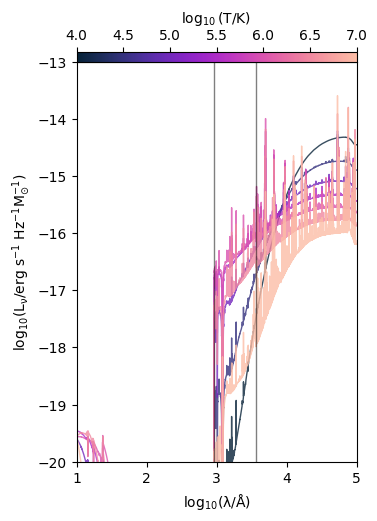

In [12]:

spectra_type = 'incident'
spectra_type = 'total'

cmap = cmr.bubblegum
norm = mpl.colors.Normalize(vmin=4., vmax=7.) 

# initialise plot
fig = plt.figure(figsize=(3.5, 5.))

left = 0.15
height = 0.8
bottom = 0.1
width = 0.8

# define main ax
ax = fig.add_axes((left, bottom, width, height))

# define colourbar ax
cax = fig.add_axes((left, bottom+height, width, 0.02))

# add colourbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')  # add the colourbar

# colourbar formatting and labelling
cax.xaxis.tick_top()
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\rm \log_{10}(T/K)$')

# loop over log10ages
for i, log10T in enumerate(grid.log10T):
    
    # get spectra
    Lnu = grid.spectra[spectra_type][i, :]
    # Lnu = fnu_to_flam(grid.lam, Lnu)

    # plot spectra
    ax.plot(np.log10(grid.lam), np.log10(Lnu), c=cmap(norm(log10T)), lw=1, alpha=0.8)

# plot Lyman and Balmer limits for reference
for wv in [912., 3646.]:
    ax.axvline(np.log10(wv), c='k', lw=1, alpha=0.5)

# set wavelength range (log(Angstrom))
ax.set_xlim([1., 5.])

# set luminosity range
ax.set_ylim([-20, -13])

# add labels
ax.set_xlabel(r'$\rm log_{10}(\lambda/\AA)$')
ax.set_ylabel(r'$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$')